# Install eeg-to-fmri package

Please check the [installation guide](https://dcalhas.github.io/eeg_to_fmri/install) before installing the package via pip.

In [1]:
!pip install --upgrade eeg-to-fmri

/bin/bash: /home/ist_davidcalhas/anaconda3/envs/eeg_fmri/lib/libtinfo.so.6: no version information available (required by /lib64/libreadline.so.7)


# EEG recoding to fMRI volume

In this post I will go over the procedure to project an EEG instance to an fMRI. This work is the core of my PhD thesis and all the findings that consequently followed. The motivation of synthesizing an fMRI volume from EEG rests on:
- An EEG recording setup is cheaper than an MRI laboratory setup;
- The fMRI recording session in itself costs hundreds of dollars, whereas an EEG recording does not;
- The main hypothesis of this work is to develop an informed fMRI view that allows better diagnosis than the EEG view alone, consequently having the potential of being applied in health care systems and reducing costs.

## What is the model?

In the [EEG to fMRI paper](https://arxiv.org/abs/2203.03481), the methodology to do this projection is presented.

This model processes two inputs:
- EEG representation $\vec{x} \in \mathbb{R}^{C \times F \times T}$;
- fMRI volume representation $\vec{y} \in \mathbb{R}^{M_1 \times M_2 \times M_3}$.

## What is an EEG?

The EEG has a drift in relation to the associated fMRI volume, since it takes into consideration $10\times \mbox{TR}$ seconds in total (for the [NODDI](https://osf.io/94c5t/) dataset this corresponds to $10\times 2.160=21.6$ seconds). In addition, the EEG has $C$ channels and $F$ frequency coefficients.

## What is an fMRI?

On the other hand, we have a **single** fMRI volume associated with the respective EEG. This fMRI is described by three dimensions, corresponding to the 3-dimensional axis, where $M_1=64$, $M_2=64$ and $M_3=30$.

## Let us dive our hands into the code! And the mathematics behind it!

In terms of code this corresponds to loading the data. First we start by import the necessary libraries:

In [2]:
import tensorflow as tf
import numpy as np
import sys

import os

#define the environment variables
os.environ['EEG_FMRI_DATASETS']="/home/ist_davidcalhas/eeg_to_fmri/datasets"
os.environ['EEG_FMRI']="/home/ist_davidcalhas/eeg_to_fmri"

import eeg_to_fmri
from eeg_to_fmri.utils import tf_config

dataset="01"
tf_config.set_seed(seed=2)
tf_config.setup_tensorflow(device="GPU", memory_limit=1500, run_eagerly=True)

from eeg_to_fmri.models.synthesizers import EEG_to_fMRI
from eeg_to_fmri.data import preprocess_data, eeg_utils, data_utils
from eeg_to_fmri.learning import train, losses
from eeg_to_fmri import metrics
from eeg_to_fmri.utils import viz_utils

Then we specify the number of individuals and $T$ (which corresponds to ```interval_eeg```), and load the data:

In [3]:
if(not os.path.exists(os.environ['EEG_FMRI']+"/datasets/01")):
    !wget web.ist.utl.pt/ist180980/eeg_to_fmri/datasets/01.zip --directory-prefix=$EEG_FMRI/datasets/
    !unzip $EEG_FMRI/datasets/01.zip -d $EEG_FMRI/datasets/

In [4]:
n_individuals=getattr(data_utils, "n_individuals_"+dataset)
interval_eeg=10

with tf.device('/CPU:0'):
    train_data, test_data = preprocess_data.dataset(dataset, n_individuals=n_individuals, interval_eeg=interval_eeg, ind_volume_fit=False, standardize_fmri=True, iqr=False, verbose=True)
    eeg_train, fmri_train =train_data
    eeg_test, fmri_test = test_data
print(eeg_train.shape, fmri_train.shape)
print(eeg_test.shape, fmri_test.shape)

I: Starting to Load Data


/home/ist_davidcalhas/anaconda3/envs/eeg_fmri/lib/python3.8/site-packages/eeg_to_fmri/data/eeg_utils.py:87: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)
/home/ist_davidcalhas/anaconda3/envs/eeg_fmri/lib/python3.8/site-packages/eeg_to_fmri/data/eeg_utils.py:87: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)
/home/ist_davidcalhas/anaconda3/envs/eeg_fmri/lib/python3.8/site-packages/eeg_to_fmri/data/eeg_utils.py:87: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preloa

I: Finished Loading Data
I: Pairs Created
(2296, 64, 134, 10, 1) (2296, 64, 64, 30, 1)
(574, 64, 134, 10, 1) (574, 64, 64, 30, 1)


In total, we are using $2296$ instances for training the model and $574$ constitute the testing set. After this we can start building the model. We first unroll the hyperparameters for the neural network: learning rate, weight decay, etc:

In [5]:
from eeg_to_fmri.models.synthesizers import parameters
learning_rate,weight_decay ,kernel_size ,stride_size ,batch_size,latent_dimension,n_channels,max_pool,batch_norm,skip_connections,dropout,n_stacks,outfilter,local=parameters

Note that both the ```eeg_to_fmri.models.synthesizers.parameters``` and the neural architectures' specification were obtained after exhaustive automatic searches. For the first, the Bayesian optimization algorithm [\[1\]](#references) was used and for the second the automatic neural architecture generation algorithm [\[2\]](#references).

With these parameters, we can finally build the model and setup the optimizer, loss, training set and test set:

In [6]:
from eeg_to_fmri.models.synthesizers import na_specification_eeg
from eeg_to_fmri.models.fmri_ae import na_specification_fmri

with tf.device('/CPU:0'):
    model = EEG_to_fMRI(latent_dimension, eeg_train.shape[1:], na_specification_eeg, n_channels,
                        weight_decay=weight_decay, skip_connections=True, batch_norm=True, fourier_features=True,
                        random_fourier=True, topographical_attention=True, conditional_attention_style=True,
                        conditional_attention_style_prior=False, local=True, seed=None, 
                        fmri_args = (latent_dimension, fmri_train.shape[1:], kernel_size, stride_size, n_channels, 
                        max_pool, batch_norm, weight_decay, skip_connections,
                        n_stacks, True, False, outfilter, dropout, None, False, na_specification_fmri))
    model.build(eeg_train.shape, fmri_train.shape)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    loss_fn = losses.mae_cosine
    train_set = tf.data.Dataset.from_tensor_slices((eeg_train, fmri_train)).batch(batch_size)
    test_set= tf.data.Dataset.from_tensor_slices((eeg_test, fmri_test)).batch(1)

2022-12-16 11:35:15.559052: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1128529920 exceeds 10% of free system memory.


Note that the loss used minimizes the objective of approximating the EEG with the fMRI, along with the latent representations of each other, meaning:

$$\mathcal{L}(\vec{x}, \vec{y}) = ||\vec{y}-\hat{y}||_1^1  + 1-\frac{\vec{z}_x \cdot \vec{z}_y}{||\vec{z}_x||_2^2\cdot ||\vec{z}_y||_2^2}$$

This loss approximates the output (predicted fMRI) with the ground truth (fMRI volume) using the L1 distance and approximates the latent representations with a pattern based (cosine) distance.

Finally, comes the fun part! The model is trained with the objective of producing an fMRI volume similar to the one paired with the given EEG:

In [7]:
train.train(train_set, model, optimizer, loss_fn, epochs=10, u_architecture=True, val_set=None, verbose=True, verbose_batch=True)

2022-12-16 11:35:16.037191: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1128529920 exceeds 10% of free system memory.
2022-12-16 11:35:17.337920: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-16 11:35:17.338235: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Epoch 1 with loss: 3.7622535594249022


2022-12-16 11:38:32.021422: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1128529920 exceeds 10% of free system memory.


Epoch 2 with loss: 1.0353693862409956


2022-12-16 11:41:46.239561: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1128529920 exceeds 10% of free system memory.


Epoch 3 with loss: 0.9767084504876818


2022-12-16 11:45:01.264905: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1128529920 exceeds 10% of free system memory.


Epoch 4 with loss: 0.9582587124370947
Epoch 5 with loss: 0.9459832190221195
Epoch 6 with loss: 0.9419807963047293
Epoch 7 with loss: 0.9396721719657087
Epoch 8 with loss: 0.9329866921652484
Epoch 9 with loss: 0.9355559302331679
Epoch 10 with loss: 0.9369906241054734


Now we have a trained model that given an EEG representation, gives us an fMRI volume. You can check the visualization by using the visualization utilities file available in this repository:

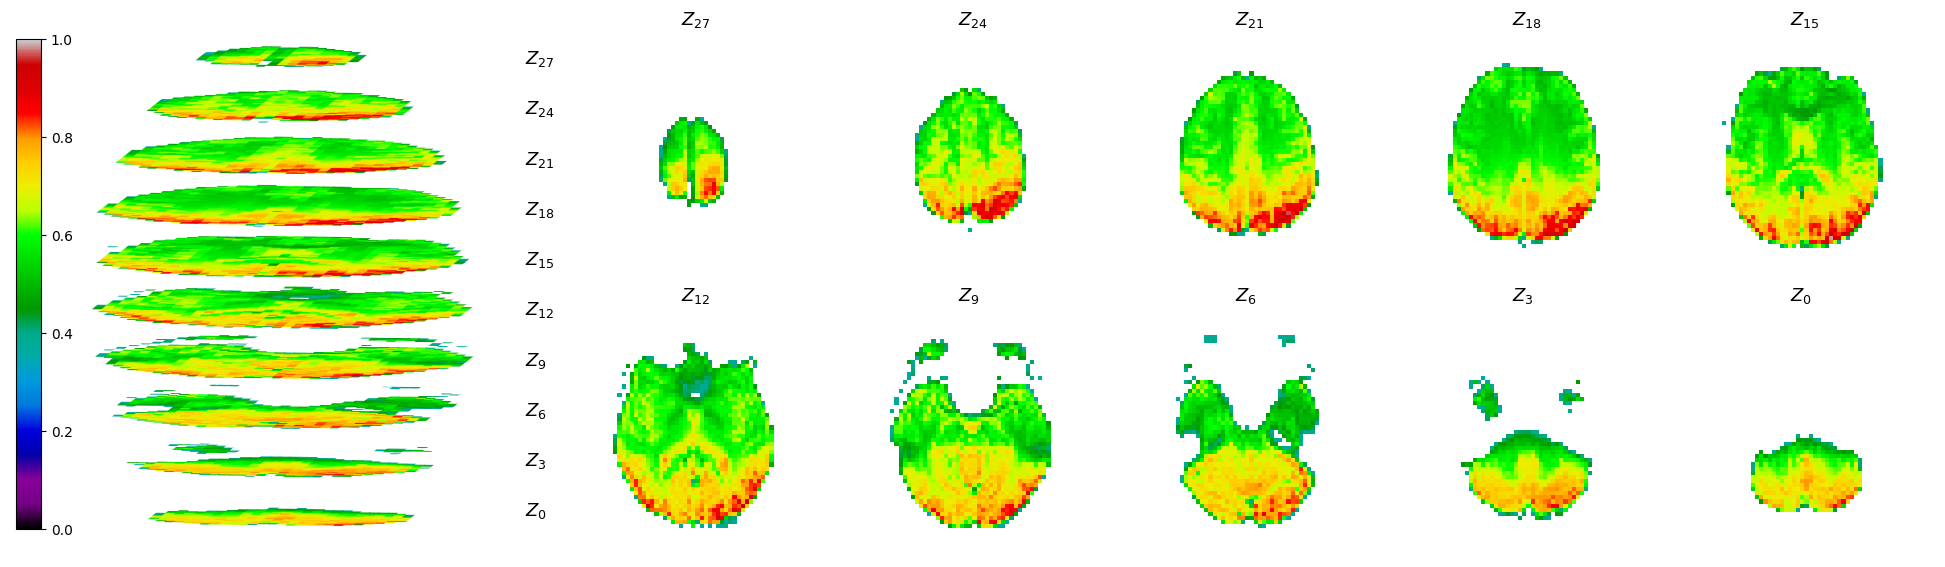

In [8]:
for eeg, fmri in test_set.repeat(1):
    viz_utils.plot_3D_representation_projected_slices(model(eeg, fmri)[0].numpy()[0], threshold=0.37).show()
    break

Note that we give as input, to the model, the EEG and the fMRI representation, however our goal is to produce an fMRI volume without an EEG reference. If we check the call function of the model, we see that it returns a list of tensors, where the first tensor is the predicted fMRI without influence of the original fMRI and only dependent on the EEG.

## References

\[1\]: [Snoek, J., Larochelle, H., & Adams, R. P. (2012). Practical bayesian optimization of machine learning algorithms. Advances in neural information processing systems, 25.](https://proceedings.neurips.cc/paper/2012/hash/05311655a15b75fab86956663e1819cd-Abstract.html)

\[2\]: [Calhas, D., Manquinho, V. M., & Lynce, I. (2021, November). Automatic Generation of Neural Architecture Search Spaces. In Combining Learning and Reasoning: Programming Languages, Formalisms, and Representations.](https://openreview.net/forum?id=TCvkaP15O7e)